In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd

from tqdm import tqdm
import os

from src.models import SpaceNetTemplate
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

Exploration

In [2]:
bs = 500

# Random context 
c = torch.tensor(np.random.choice([0, 1, 2], bs), dtype=torch.float32)

# Create random embeddings
embeddings = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32, requires_grad=True)
with torch.no_grad():
    embeddings /= torch.norm(embeddings, dim=1, keepdim=True)

# Compute the centroids of p for all distinct y values
C = torch.stack([embeddings[c == i].mean(dim=0) for i in torch.unique(c)])

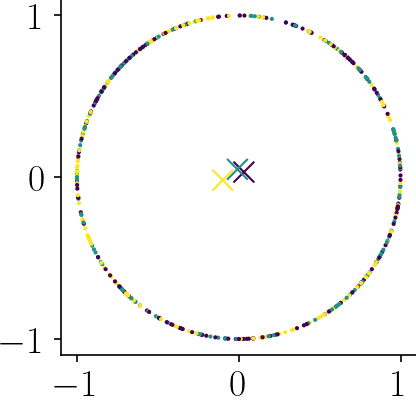

In [3]:
old_c = C.detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(embeddings[:, 0].detach().numpy(), embeddings[:, 1].detach().numpy(), c=c, cmap='viridis') 
ax.scatter(old_c[:, 0], old_c[:, 1], c=sorted(torch.unique(c)), cmap='viridis', marker='x', s=100)
ax.set_ylim(-1.1, 1.1)  
ax.set_xlim(-1.1, 1.1)
ax.set_aspect('equal')

In [4]:
lr = 1e-2
num_epochs = 100000

# Optimizer
optimizer = torch.optim.SGD([embeddings], lr=lr)

# Training loop
losses = []

pb = tqdm(range(num_epochs))
for epoch in pb:
    optimizer.zero_grad()  # Zero the gradients

    # Compute the centroids for each context value
    C = torch.stack([embeddings[c == i].mean(dim=0) for i in torch.unique(c)])

    # Perform SVD to get the singular values of the centroid matrix
    _, singular_values, _ = torch.svd(C)

    # Compute the nuclear norm (sum of singular values)
    nuclear_norm = torch.sum(singular_values)

    # Loss is the negative of the nuclear norm
    loss = -nuclear_norm

    # Backpropagate to compute gradients
    loss.backward()

    # Update embeddings using gradient descent
    optimizer.step()

    # Normalize the embeddings after each update (to keep them on the hypersphere)
    with torch.no_grad():
        embeddings[:] = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        pb.set_description(f"Epoch {epoch}, Loss: {loss.item():.2f}")
        
    # Save the loss
    losses.append(loss.item())


Epoch 99900, Loss: -2.41: 100%|██████████| 100000/100000 [00:38<00:00, 2567.81it/s]


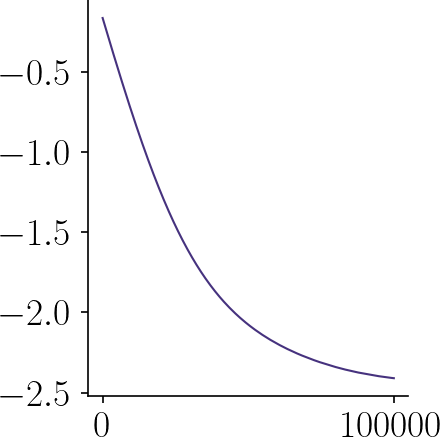

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(losses)
plt.show()

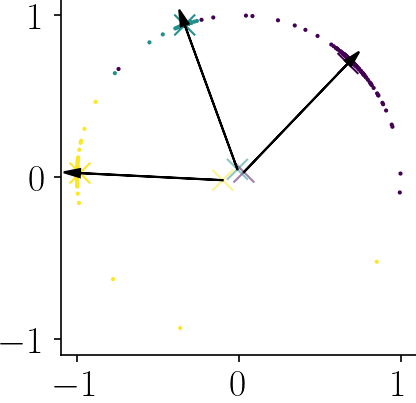

In [6]:
new_c = C.detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(embeddings[:, 0].detach().numpy(), embeddings[:, 1].detach().numpy(), c=c, cmap='viridis') 
ax.scatter(C[:, 0].detach().numpy(), C[:, 1].detach().numpy(), c=sorted(torch.unique(c)), cmap='viridis', marker='x', s=100)
# Old c
ax.scatter(old_c[:, 0], old_c[:, 1], c=sorted(torch.unique(c)), cmap='viridis', marker='x', s=100, alpha=0.5)

# Arrow from old to new
for i in sorted(torch.unique(c).numpy().astype(int)):
    diff = new_c[i] - old_c[i]
    # ax.arrow(old_c[i, 0], old_c[i, 1], diff[0] - (0.1 * np.sign(new_c[i, 0])), diff[1] - (0.1 * np.sign(new_c[i, 1])), head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(old_c[i, 0], old_c[i, 1], diff[0], diff[1], head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.set_ylim(-1.1, 1.1)  
ax.set_xlim(-1.1, 1.1)
ax.set_aspect('equal')

Training

In [112]:
def get_spatial_representation(model, n_grid, val_range=(-1, 1), env='square', width=2, height=2):
    """
    Get spatial representation of model on a grid.

    Parameters
    ----------
    model : torch.nn.Module
        Model to evaluate.
    n_grid : int
        Number of points on grid.
    val_range : tuple, optional
        Range of values on grid, by default (-1, 1).
    env : str, optional
        Environment to evaluate in, by default 'square'.
    width : int, optional
        Width of the environment, by default 2.
    height : int, optional
        Height of the environment, by default 2.

    Returns
    -------
    np.ndarray
        Spatial representation of model on grid.

    """
    
    x = np.linspace(-width/2, width/2, n_grid)
    y = np.linspace(-height/2, height/2, n_grid)
    xx, yy = np.meshgrid(x,y)
    
    if env == 'circle':
        # Flatten the meshgrid to work with the points as vectors
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        
        # Calculate the distance from the origin
        distance = np.sqrt(xx_flat**2 + yy_flat**2)
        
        # Filter the points to include only those within the circle of radius 1
        inside_circle = distance <= 1
        xx = xx_flat[inside_circle]
        yy = yy_flat[inside_circle]   
    
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
    p = model.spatial_representation(u).detach().numpy()
    
    if env == 'circle':
        # Create a grid of nans
        total_p = np.full((n_grid**2, p.shape[-1]), np.nan)
        total_p[inside_circle] = p
        return total_p

    return p

In [169]:
class CapacitySpaceNet(SpaceNetTemplate):
    """Feedforward SpaceNet model with a single hidden layer."""

    def __init__(self, n_in, n_out, cap, **kwargs):
        super().__init__(**kwargs)
        self.spatial_representation = torch.nn.Sequential(
            torch.nn.Linear(n_in, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, n_out),
            torch.nn.ReLU()
        )
        self.to(self.device)
        torch.nn.init.kaiming_uniform_(self.spatial_representation[0].weight)
        torch.nn.init.kaiming_uniform_(self.spatial_representation[2].weight)
        torch.nn.init.kaiming_uniform_(self.spatial_representation[4].weight)
        
        self.cap = cap
    
    # def loss_fn(self, x, y):
    #     # x = inputs to model, y = labels
    #     corr, p = self(x)
    #     label_corr = self.correlation_function(y)
    #     label_corr = label_corr*(1 - self.beta) + self.beta # normalize to [beta, 1]
    #     loss = torch.mean((corr - label_corr) ** 2)
    #     return loss + self.lam*torch.mean(p**2)
        
    def forward(self, inputs, **kwargs):
        p = self.spatial_representation(inputs)  # ns, nr
        
        # Normalize the spatial representation to have unit norm
        p = p / torch.norm(p, dim=1, keepdim=True)
        
        dp = torch.pdist(p) **2
        corr = torch.exp(-dp)
        return corr, p

    def correlation_function(self, r):        
        dr = torch.nn.functional.pdist(r) **2
        correlation = torch.exp(-0.5 / self.scale ** 2 * dr)
        return correlation

    
    def capacity_loss(self, p, y):
        
        # p is (bs, n_out)
        
        # Normalize rows of p to have unit norm
        # p = p / torch.norm(p, dim=1, keepdim=True)
        
        # Compute the centroids of p for all distinct y values
        C = torch.stack([p[y == i].mean(dim=0) for i in torch.unique(y)])
        
        # # Check if the variance of C is too small or degenerate
        # if torch.var(C) < 1e-6:
        #     return torch.tensor(0.0, device=p.device)  # Skip the SVD if the centroids are too similar
        # 
        # try:
        #     # Compute singular values of the centroid matrix
        #     _, singular_values, _ = torch.linalg.svd(C, full_matrices=False)
        # except RuntimeError as e:
        #     return torch.tensor(0.0, device=p.device)
        
        # # Compute the pseudoinverse of the centroid matrix
        # C_pinv = torch.linalg.pinv(C)
        # 
        # # Compute a measure of the "complexity" or "size" of the matrix
        # # For example, we can use the trace of C_pinv
        # nuclear_norm = torch.sum(C_pinv)
        
        # Add a small perturbation to the centroid matrix to avoid degeneracy
        # C = C + 1e-6 * torch.randn_like(C)
        # 
        # Compute singular values of the centroid matrix
        _, singular_values, _ = torch.linalg.svd(C, full_matrices=False)

        # Compute the nuclear norm by summing the singular values
        nuclear_norm = torch.sum(singular_values)
        
        return -nuclear_norm
        
    def loss_fn(self, x, ys, **kwargs):
        """Loss function

        Args:
            x: Torch tensor of shape (batch size, 3). The function assumes
            that the first two components are spatial coordinates, while
            the last is a context coordinate.
            ys:  A tuple of tensors.

        Returns:
            loss (1D tensor)
        """
        # Get output of the model, which is the correlations (corr)
        # and the spatial representation (p)
        corr, p = self.forward(x)
        
        # Compute the labels for space
        labels = self.correlation_function(ys[0])
        labels = labels * (1 - self.beta) + self.beta # Normalize the labels to [beta, 1]  
        
        # Compute loss between the correlations and the labels
        loss = torch.mean((corr - labels) ** 2)
        
        # Regularization term
        reg_loss = torch.mean(p**2)
        
        # Capacity term
        cap_loss = self.capacity_loss(p, ys[1])
        
        # Add regularization term
        total_loss = loss + self.lam * reg_loss + self.cap * cap_loss  

        return {'total': total_loss, 'loss': loss, 'reg': reg_loss, 'cap': cap_loss}
 
    def train_step(self, x, y, optimizer):
        """Perform a single training step and returns the loss.
        """
        optimizer.zero_grad()
        loss_dict = self.loss_fn(x, y)
        loss = loss_dict['total']
        loss.backward()
        optimizer.step()
        return {k: v.item() for k, v in loss_dict.items()}

In [231]:
# ----------------------- Params -----------------------
train_steps = 10000      # no. of training steps
bs = 128                # batch size
n_in = 3                # 2 position inputs
n_out = 500             # 100 output neurons
scale = 0.25            # scale of the gaussian
lam = 0.3                 # regularization strength
lr = 1e-2               # learning rate
beta = 0.0              # rescaling parameter
cap = 0.1              # capacity parameter

In [232]:
model = CapacitySpaceNet(n_in=n_in, n_out=n_out, scale=scale, lam=lam, beta=beta, cap=cap)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

contexts = [0, 1, 2, 3, 4]

# Train model
loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Random positions 
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype=torch.float32)
    
    # Random context 
    c = torch.tensor(np.random.choice(contexts, bs), dtype=torch.float32)
    # c = torch.tensor(np.random.uniform(-5, 5, bs), dtype=torch.float32)

    inputs = torch.cat((r, c[:, None]), dim=-1)
    labels = (r, c)
    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    # Save loss
    loss_history.append(loss)

    # Update progress bar
    if i % 10 == 0:
        progress.set_description(f"loss: {loss['total']:>7f}")

loss: -0.351981: 100%|██████████| 10000/10000 [00:30<00:00, 325.16it/s]


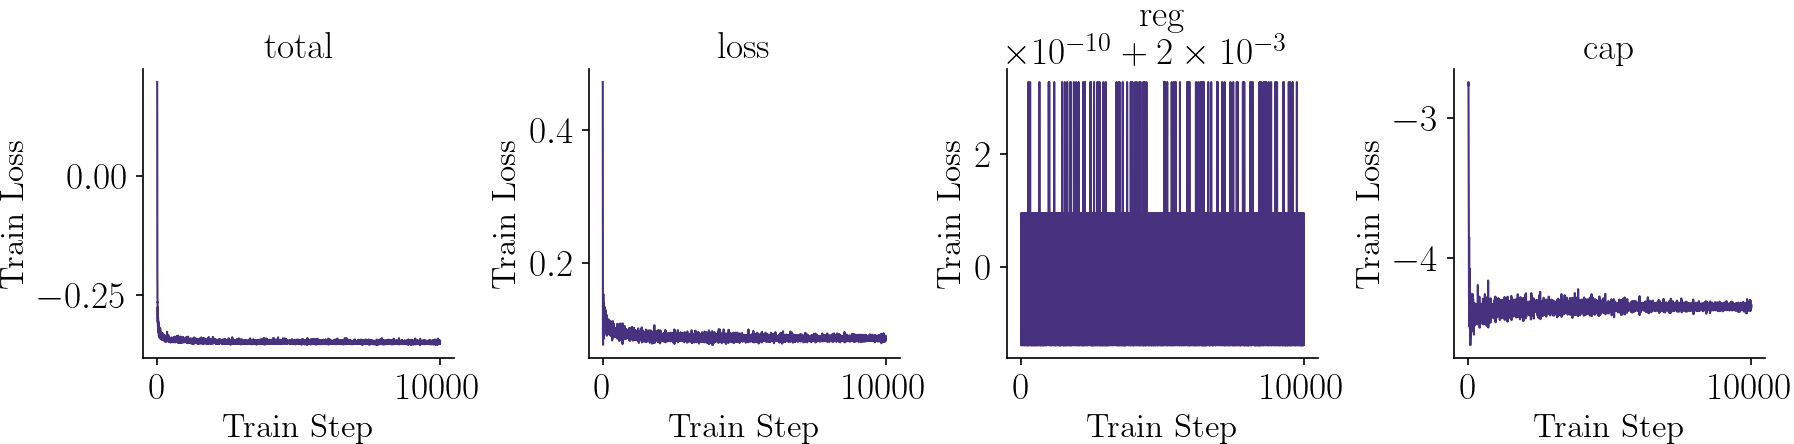

In [233]:
fig, axs = plt.subplots(figsize=(3 * len(loss_history[0]), 3), ncols=len(loss_history[0]), sharey=False)
for i, (k, v) in enumerate(loss_history[0].items()):
    axs[i].plot(np.arange(len(loss_history)), [x[k] for x in loss_history])
    axs[i].set_title(k)
    axs[i].set_xlabel("Train Step")
    axs[i].set_ylabel("Train Loss")
plt.show()

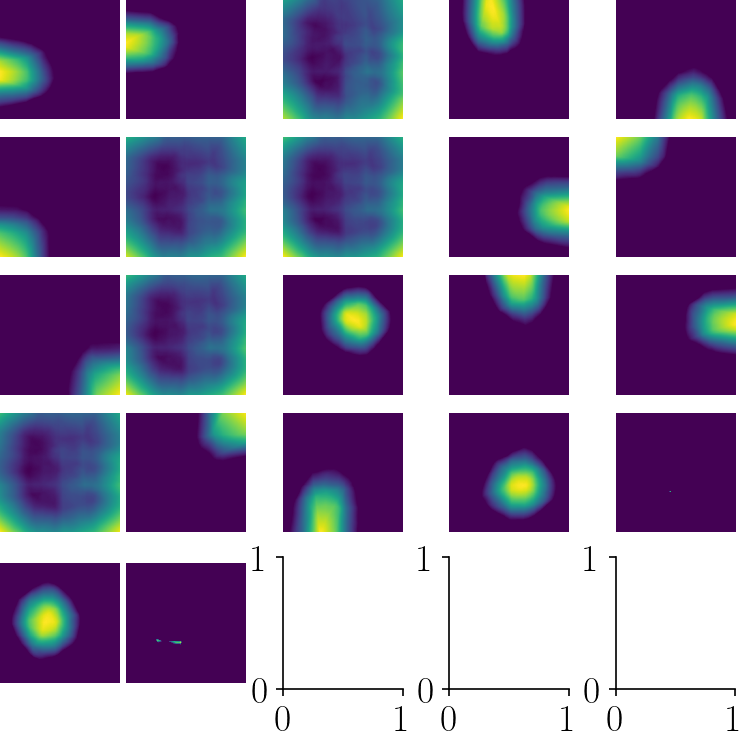

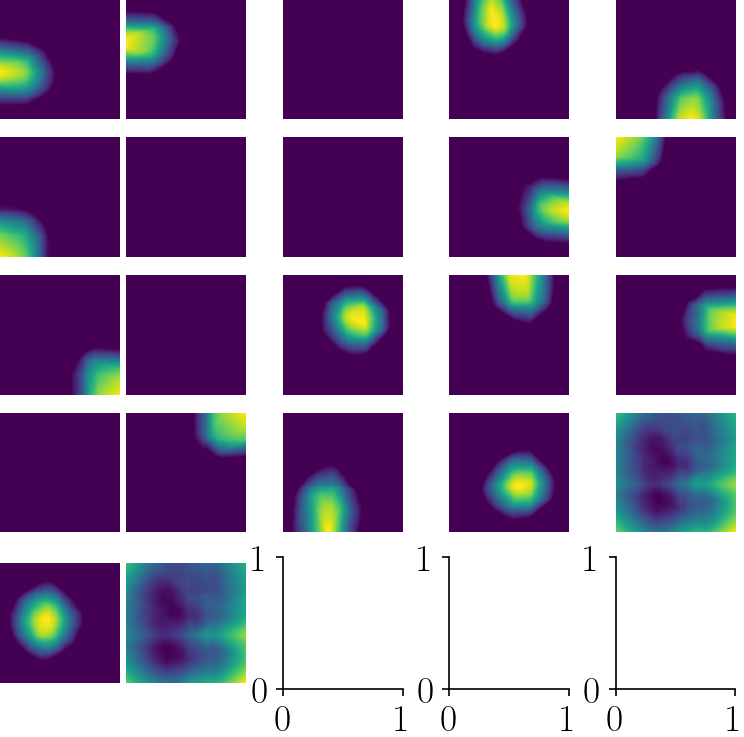

In [234]:
c = 0
n_grid = 1024
x = np.linspace(-1, 1, n_grid)
y = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x,y)

cs = np.ones_like(xx) * c

u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), cs.ravel()], axis=-1), dtype=torch.float32)
p = model.spatial_representation(u).detach().numpy()

# Find cells with nonzero values
mask = np.nanmean(p, axis=0) > 0
ratemaps = p.T[mask].reshape(-1, n_grid, n_grid)

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(ratemaps[:25], cmap="viridis", figsize=(5, 5))     # jet, viridis
plt.show()

# Get the spatial representation of the model for c=1
c = 1

cs = np.ones_like(xx) * c
u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), cs.ravel()], axis=-1), dtype=torch.float32)
p = model.spatial_representation(u).detach().numpy()

# Note: use the same mask as before
ratemaps = p.T[mask].reshape(-1, n_grid, n_grid)

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(ratemaps[:25], cmap="viridis", figsize=(5, 5))     # jet, viridis
plt.show()

# fig.savefig(os.path.join(figure_path, f'dense_ratemaps_{model_name}.svg'), transparent=True)

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_6518/4037981630.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0, wspace=0.1)


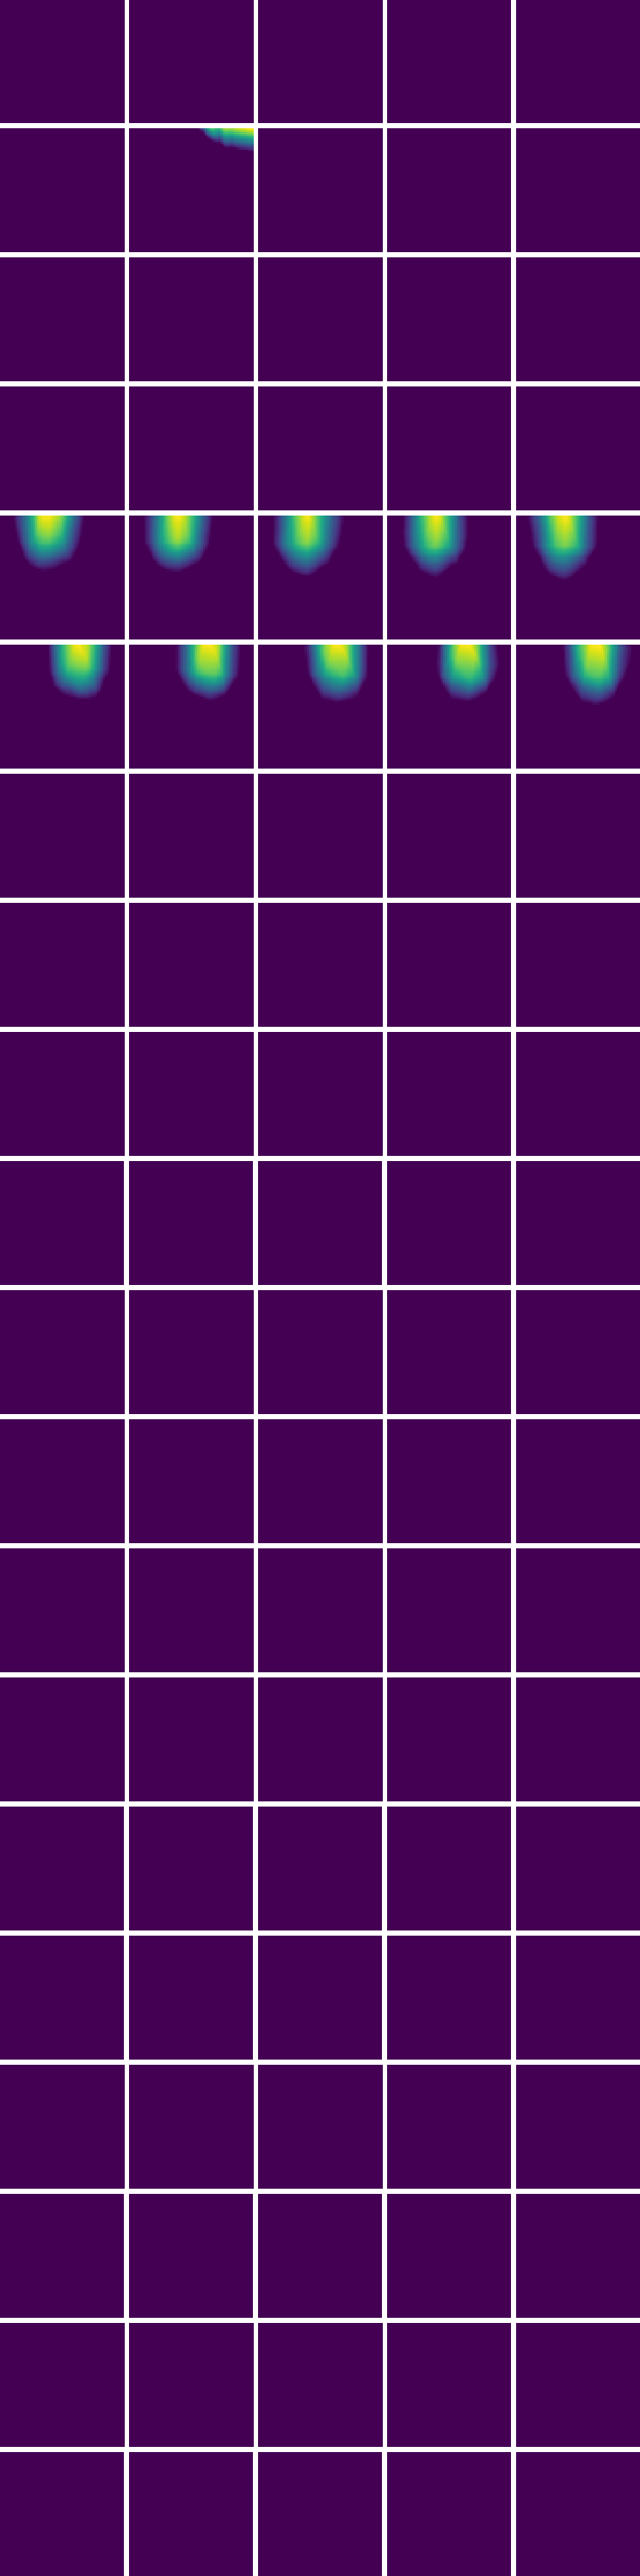

In [235]:
n = 20 # number of units to visualize
n_grid = 64
fig, ax = plt.subplots(nrows=n, ncols=len(contexts), figsize=(len(contexts) * 1, n * 1))

x = np.linspace(-1, 1, n_grid)
y = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x,y)

corrs = []
for i, c in enumerate(contexts):
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c*torch.ones(n_grid**2)], axis=-1), dtype=torch.float32)
    p = model.spatial_representation(u).detach().numpy()
    for j in range(n):
        ax[j, i].imshow(p[..., j].reshape(n_grid, n_grid), cmap='viridis')
        ax[j, i].axis("off")
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

In [236]:
n_grid = 64
representations = []
for context in contexts:
    c = context
    
    x = np.linspace(-1, 1, n_grid)
    y = np.linspace(-1, 1, n_grid)
    xx, yy = np.meshgrid(x,y)

    cs = np.ones_like(xx) * c

    u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), cs.ravel()], axis=-1), dtype=torch.float32)
    p = model.spatial_representation(u).detach().numpy()

    representations.append(p)

representations = np.concatenate(representations, axis=0)

In [237]:
representations.shape

(20480, 500)

In [238]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_trajectories = reducer.fit_transform(representations)

/Users/frederikrogge/miniforge3/envs/bsr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot: >

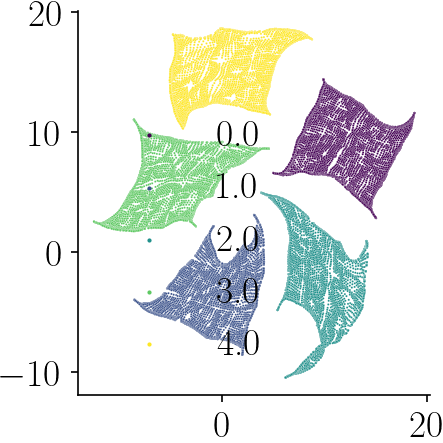

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(x=umap_trajectories[:, 0], y=umap_trajectories[:, 1], hue=np.concatenate([np.ones(n_grid**2)*c for c in contexts]), palette='viridis', ax=ax)